In [2]:
from datetime import datetime, timedelta
from app.tasks.generation import generation as generation_task
import pandas as pd
import numpy as np

In [7]:
%matplotlib inline

In [8]:
data = pd.read_csv('../data/generation_2017.csv')

In [9]:
data.shape

(8030, 13)

In [10]:
data.sample(n=5)

,timestamp,biomass,coal,fossil,hydro,natgas,oil,other,refuse,solar,wind,renewables,non_renewables
766,2017-02-04 20:00:00,1299.0,9683.0,73.0,200.0,823.0,204.0,158.0,0.0,0.0,1822.0,3321.0,10942.0
6943,2017-11-12 15:00:00,1198.0,10952.0,72.0,157.0,564.0,198.0,157.0,306.0,2.0,550.0,1908.0,12249.0
1720,2017-03-20 06:00:00,1291.0,8470.0,72.0,1242.0,652.0,186.0,155.0,0.0,242.0,5748.0,8524.0,9535.0
604,2017-01-28 12:00:00,1334.0,9624.0,72.0,288.0,840.0,203.0,157.0,0.0,3388.0,1175.0,6186.0,10896.0
5268,2017-08-28 12:00:00,1088.0,8778.0,16.0,322.0,166.0,210.0,34.0,268.0,5444.0,43.0,6897.0,9473.0


In [12]:
data['renewables_ratio'] = data['renewables'] / (data['renewables'] + data['non_renewables'])

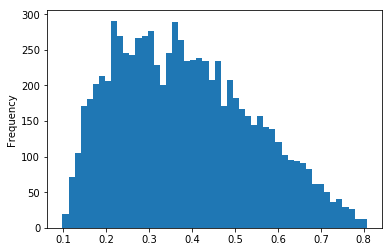

In [19]:
data['renewables_ratio'].plot(kind='hist', bins=50)